# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

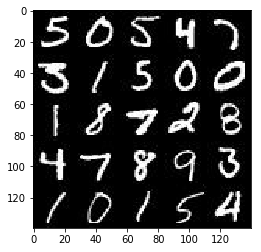

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

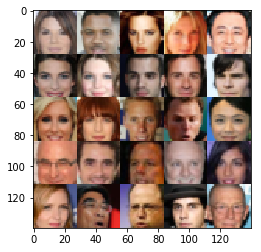

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [52]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 3x3x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 3*3*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [53]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now
        
        x1_5 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')
        x1_5 = tf.layers.batch_normalization(x1_5, training=is_train)
        x1_5 = tf.maximum(alpha * x1_5, x1_5)
        # 7x7x256now
       
        x2 = tf.layers.conv2d_transpose(x1_5, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        out = tf.tanh(logits)
        
        return out
    
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [54]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [55]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    print("data ",data_shape, data_image_mode)
    
    losses = []
    steps = 0
    
    
    input_real, input_z, input_learning_rate = model_inputs(
        data_shape[1],data_shape[2],data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 6*12, input_z, data_shape[3],data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data  (60000, 28, 28, 1) L
Epoch 1/2... Discriminator Loss: 1.7606... Generator Loss: 0.3715
Epoch 1/2... Discriminator Loss: 0.7308... Generator Loss: 1.0761
Epoch 1/2... Discriminator Loss: 0.5373... Generator Loss: 1.7713
Epoch 1/2... Discriminator Loss: 0.8375... Generator Loss: 1.4962
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 1.1340
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 1.5960
Epoch 1/2... Discriminator Loss: 0.6598... Generator Loss: 1.4663
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 0.5111
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 1.4698


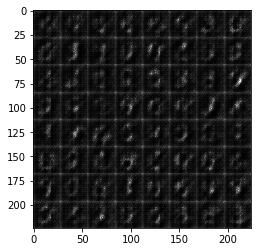

Epoch 1/2... Discriminator Loss: 0.7082... Generator Loss: 1.1218
Epoch 1/2... Discriminator Loss: 0.9636... Generator Loss: 0.9754
Epoch 1/2... Discriminator Loss: 0.8858... Generator Loss: 1.1014
Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 1.6412
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 1.1938
Epoch 1/2... Discriminator Loss: 0.8214... Generator Loss: 1.7257
Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 1.1113
Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 1.8960


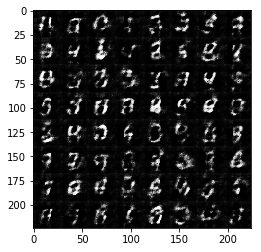

Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 1.2095
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.4835
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 1.2643
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 1.0900
Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 1.5033
Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 1.6800
Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 1.3339
Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 1.1020
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 0.6670


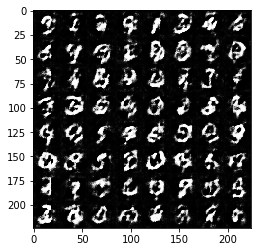

Epoch 1/2... Discriminator Loss: 0.7573... Generator Loss: 1.2627
Epoch 1/2... Discriminator Loss: 0.7032... Generator Loss: 1.6750
Epoch 1/2... Discriminator Loss: 0.7645... Generator Loss: 1.6814
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 0.6748... Generator Loss: 1.3059
Epoch 1/2... Discriminator Loss: 0.6389... Generator Loss: 1.6930
Epoch 1/2... Discriminator Loss: 0.6920... Generator Loss: 1.1900
Epoch 1/2... Discriminator Loss: 0.8857... Generator Loss: 1.4762
Epoch 1/2... Discriminator Loss: 0.7178... Generator Loss: 1.2064
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 0.7183


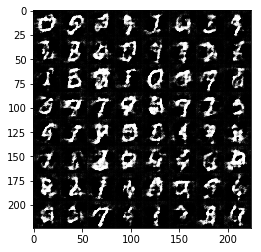

Epoch 1/2... Discriminator Loss: 0.8636... Generator Loss: 0.8448
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.3905
Epoch 1/2... Discriminator Loss: 0.8425... Generator Loss: 0.8321
Epoch 1/2... Discriminator Loss: 0.8319... Generator Loss: 0.8511
Epoch 1/2... Discriminator Loss: 0.7143... Generator Loss: 1.1764
Epoch 1/2... Discriminator Loss: 0.7575... Generator Loss: 1.1710
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.2418
Epoch 2/2... Discriminator Loss: 0.8533... Generator Loss: 1.4381
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 1.8336


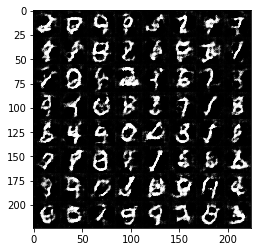

Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 0.8398
Epoch 2/2... Discriminator Loss: 0.8010... Generator Loss: 1.3746
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 0.9491
Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 0.8939
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 0.9603
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 0.7478
Epoch 2/2... Discriminator Loss: 0.8618... Generator Loss: 0.8823
Epoch 2/2... Discriminator Loss: 0.8528... Generator Loss: 0.8593
Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.3718
Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 0.8274


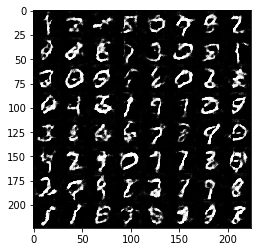

Epoch 2/2... Discriminator Loss: 0.7453... Generator Loss: 1.0128
Epoch 2/2... Discriminator Loss: 0.8379... Generator Loss: 1.7972
Epoch 2/2... Discriminator Loss: 0.8000... Generator Loss: 0.9395
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 2.1774
Epoch 2/2... Discriminator Loss: 0.8269... Generator Loss: 0.9199
Epoch 2/2... Discriminator Loss: 0.8744... Generator Loss: 1.7738
Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.2584
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 0.6209
Epoch 2/2... Discriminator Loss: 0.8444... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 1.6196


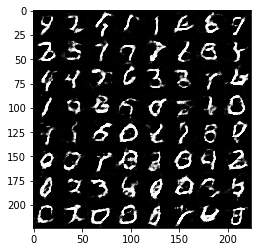

Epoch 2/2... Discriminator Loss: 0.9901... Generator Loss: 0.6603
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 0.9586
Epoch 2/2... Discriminator Loss: 0.7837... Generator Loss: 1.0010
Epoch 2/2... Discriminator Loss: 0.8158... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.1433
Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 0.7981
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 0.8800
Epoch 2/2... Discriminator Loss: 0.7326... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 2.3409
Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 0.8053


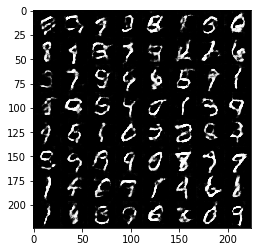

Epoch 2/2... Discriminator Loss: 0.8264... Generator Loss: 0.7914
Epoch 2/2... Discriminator Loss: 0.6435... Generator Loss: 1.5592
Epoch 2/2... Discriminator Loss: 0.8263... Generator Loss: 1.6935
Epoch 2/2... Discriminator Loss: 0.7153... Generator Loss: 1.2385
Epoch 2/2... Discriminator Loss: 0.6643... Generator Loss: 1.3589
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.2971
Epoch 2/2... Discriminator Loss: 1.5921... Generator Loss: 0.2831
Epoch 2/2... Discriminator Loss: 0.6554... Generator Loss: 1.2107
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 1.7263


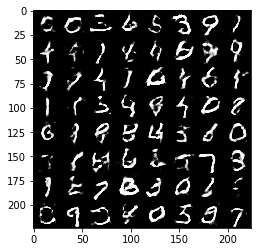

Epoch 2/2... Discriminator Loss: 0.6239... Generator Loss: 1.3743
Epoch 2/2... Discriminator Loss: 0.7640... Generator Loss: 0.9261
Epoch 2/2... Discriminator Loss: 0.6649... Generator Loss: 1.6243


In [58]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data  (202599, 28, 28, 3) RGB
Epoch 1/1... Discriminator Loss: 2.0942... Generator Loss: 0.2437
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.1366
Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 1.6872
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 1.8934
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.6291
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 0.7020


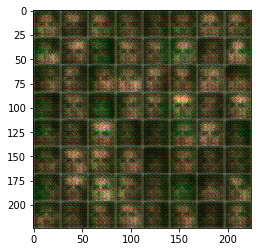

Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.1139
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 1.6237
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.1596
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.6162


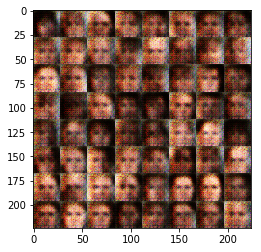

Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.6675
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 1.7943
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.5417
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.3925
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.0667


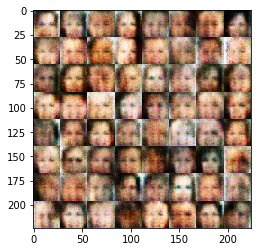

Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 2.1209
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.5950... Generator Loss: 0.3483
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.3799
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.2727
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.3860


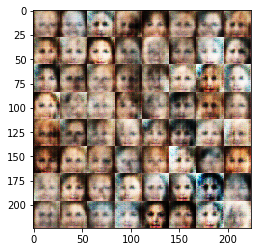

Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.6236
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.2390
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.2661
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.4573
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.2565
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.3552


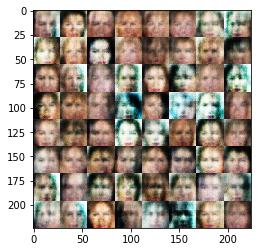

Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 1.4351
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.5223
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.8289... Generator Loss: 0.2504
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.5360


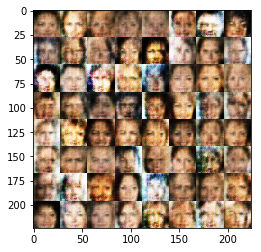

Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.2427
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.3357
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.8238


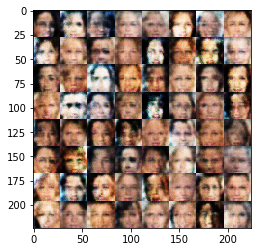

Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.2379
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.2116
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.2468


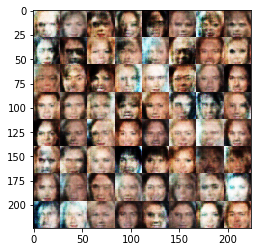

Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.1735
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.7400
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.7511


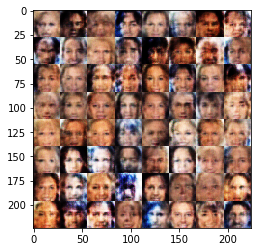

Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.3786


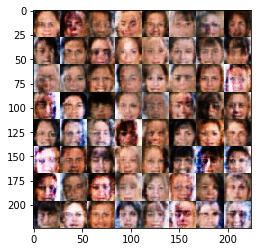

Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.3006
Epoch 1/1... Discriminator Loss: 1.7928... Generator Loss: 0.2730
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 0.9620


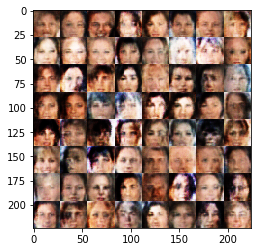

Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 1.2769
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.4393


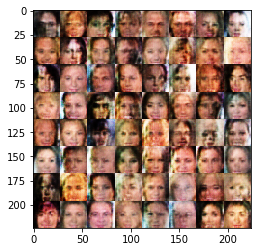

Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.3316
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.6038
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.2814
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.3283


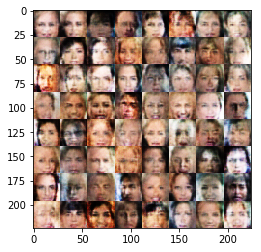

Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.9572
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.6317


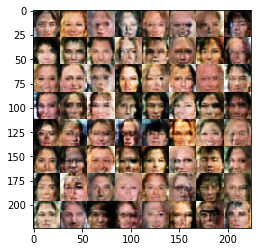

Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.2231
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.0400


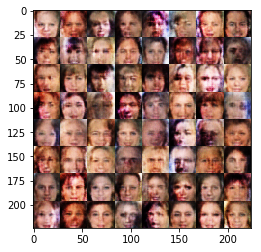

Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.6953


In [59]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.